In [1]:
%matplotlib inline 
import math
import time
import sys
from datetime import datetime
import numpy as np # numerical computation packages in python
import matplotlib.pyplot as plt # plotting routines
import pandas as pd
import multiprocessing as mp

from statsmodels.tsa.stattools import adfuller
from joblib import dump, load
from sklearn import svm

In [2]:
candles1Yr = pd.read_csv('../data/candles_BTC_USDT_12mo.csv', sep=';', index_col=0, parse_dates=True)
candlesSmall = candles1Yr.tail(math.floor(candles1Yr.shape[0] * 0.05))

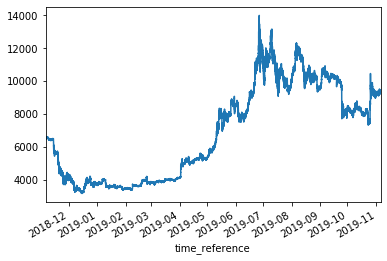

In [3]:
candles1Yr.close.plot()

In [4]:
candles1Yr

,open,high,low,close,volume,count,buy_volume,buy_count,sell_volume,sell_count,last_updated
time_reference,,,,,,,,,,,
2018-11-06 00:00:00,6467.0947,6467.0976,6465.4643,6467.0954,0.405219,20,0.056455,8,0.348764,12,2019-03-26 11:00:26
2018-11-06 00:00:30,6467.0951,6467.3660,6465.3297,6467.3660,4.879489,24,4.738119,18,0.141370,6,2019-03-26 11:01:36
2018-11-06 00:01:00,6465.5125,6469.7385,6465.3278,6469.7385,3.045948,47,2.845258,33,0.200690,14,2019-03-26 10:59:43
2018-11-06 00:01:30,6468.3192,6471.6717,6468.0478,6470.1423,4.270529,102,1.078911,35,3.191618,67,2019-03-26 11:00:19
2018-11-06 00:02:00,6469.8302,6470.7214,6468.1362,6468.1373,6.888927,58,0.397990,15,6.490937,43,2019-03-26 11:00:45
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-05 23:57:30,9305.3000,9305.3000,9302.6000,9302.6000,0.163570,5,0.000000,0,0.163570,5,2019-11-05 23:58:06
2019-11-05 23:58:00,9305.0000,9305.0000,9292.6000,9292.9000,6.714134,125,0.941656,40,5.772477,85,2019-11-05 23:58:30
2019-11-05 23:58:30,9292.9000,9295.4000,9292.9000,9293.7000,1.128454,27,0.988972,22,0.139482,5,2019-11-05 23:59:16


## Chapter 2: Data Structures
CUSUM filtering of price data

In [5]:
def getTEvents(gRaw,h):
    tEvents,sPos,sNeg = [],0,0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos,sNeg = max(0,sPos+diff.loc[i]),min(0,sNeg+diff.loc[i])
        if sNeg<-h:
            sNeg = 0;tEvents.append(i)
        elif sPos>h:
            sPos = 0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

## Chapter 20: Multiprocessing 

In [6]:
## Multiprocessing stuff, used for triple-barrier.

def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts = np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts = np.ceil(parts).astype(int)
    return parts

def nestedParts(numAtoms,numThreads,upperTriang = False):
    # partition of atoms with an inner loop
    parts,numThreads_ = [0],min(numThreads,numAtoms)
    for num in xrange(numThreads_):
        part = 1 + 4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part = (-1+part**.5)/2.
        parts.append(part)
    parts = np.round(parts).astype(int)
    if upperTriang: # the first rows are the heaviest
        parts = np.cumsum(np.diff(parts)[::-1])
        parts = np.append(np.array([0]),parts)
    return parts

def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out = []
    for job in jobs:
        out_ = expandCall(job)
        out.append(out_)
    return out

#———————————————————————————————————————
def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg = [float(jobNum)/numJobs,(time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp = str(datetime.fromtimestamp(time.time()))
    msg = timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+' \ r')
    else:sys.stderr.write(msg+' \ n')
    return
#———————————————————————————————————————
def processJobs(jobs,task = None,numThreads = 24):
    # Run in parallel.
    # jobs must contain a ’func’ callback, for expandCall
    if task is None:task = jobs[0]['func'].__name__
    pool = mp.Pool(processes = numThreads)
    outputs,out,time0 = pool.imap_unordered(expandCall,jobs),[], time.time()
    # Process asynchronous output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

def expandCall(kargs):
    # Expand the arguments of a callback function, kargs[’func’]
    func = kargs['func']
    del kargs['func']
    out = func( ** kargs)
    return out

def mpPandasObj(func,pdObj,numThreads = 24,mpBatches = 1,linMols = True,**kargs):
    '''
    Parallelize jobs, return a DataFrame or Series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kargs: any other argument needed by func
    Example: df1 = mpPandasObj(func,(’molecule’,df0.index),24,**kargs)
    '''
    if linMols:
        parts = linParts(len(pdObj[1]),numThreads*mpBatches)
    else:
        parts = nestedParts(len(pdObj[1]),numThreads*mpBatches)
    jobs = []
    for i in range(1,len(parts)):
        job = { pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func }
        job.update(kargs)
        jobs.append(job)
    if numThreads == 1:
        out = processJobs_(jobs)
    else:
        out = processJobs(jobs,numThreads = numThreads)
    if isinstance(out[0],pd.DataFrame):
        df0 = pd.DataFrame()
    elif isinstance(out[0],pd.Series):
        df0 = pd.Series()
    else:
        return out
    for i in out:
        df0 = df0.append(i)
    df0 = df0.sort_index()
    return df0

# Chapter 3: Labelling
Triple-barrier method

In [7]:
def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep = True)
    if ptSl[0]>0:
        pt = ptSl[0]*events_['trgt']
    else:
        pt = pd.Series(index = events.index) # NaNs
    if ptSl[1]>0:
        sl = -ptSl[1]*events_['trgt']
    else:
        sl = pd.Series(index = events.index) # NaNs
        
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] # path prices
        df0 = (df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl'] = df0[df0<sl[loc]].index.min() # earliest stop loss.
        out.loc[loc,'pt'] = df0[df0>pt[loc]].index.min() # earliest profit taking.
        
    return out

## An example vertical barrier (to pass to getEvents)
#t1 = close.index.searchsorted(tEvents+pd.Timedelta(days = numDays))
#t1 = t1[t1<close.shape[0]]
#t1 = pd.Series(close.index[t1],index = tEvents[:t1.shape[0]]) # NaNs at end


## Find time of first touch (of any of the three barriers)
# parameters:
# close = price series
# tEvents = timeindex containing the timestamps selected by sampling (eg. CUSUM)
# ptSl = a single non-negative float to set width of both barriers
# t1 = timestamps of vertical barriers (False if vert. barriers should be disabled)
# trgt = pandas series of target absolute returns
# minRet = minimum target return to run a triple barrier search
# numThreads = number of threads for the function to use
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1 = False):
    #1) get target
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt>minRet] # minRet
    
    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT,index = tEvents)
        
    #3) form events object, apply stop loss on t1
    side_ = pd.Series(1.,index = trgt.index)
    events = pd.concat( { 't1':t1, 'trgt':trgt, 'side':side_ } , \
    axis = 1).dropna(subset = ['trgt'])
    df0 = mpPandasObj(func = applyPtSlOnT1, pdObj = ('molecule',events.index), \
    numThreads = numThreads, close = close, events = events, ptSl = [ptSl,ptSl])
    events['t1'] = df0.dropna(how = 'all').min(axis = 1) # pd.min ignores nan
    events = events.drop('side', axis = 1)
    return events

## Label observations found with getEvents
# returns: a dataframe with two columns
# ret: The return realized at the time of the first touched barrier.
# bin: The label, {−1, 0, 1}, as a function of the sign of the outcome.
def getBins(events, close):
    #1) prices aligned with events
    events_ = events.dropna(subset = ['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px,method = 'bfill')
    
    #2) create out object
    out = pd.DataFrame(index = events_.index)
    out['ret'] = px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin'] = np.sign(out['ret'])
    return out

## Chapter 5: Fractionally differentiated features

In [8]:
def get_weights_ffd(diff_amt, thresh, lim):
    """
    Source: Chapter 5, AFML (section 5.4.2, page 83)
    The helper function generates weights that are used to compute fractionally
    differentiate dseries. It computes the weights that get used in the computation
    of fractionally differentiated series. The series is of fixed width and same
    weights (generated by this function) can be used when creating fractional
    differentiated series.
    This makes the process more efficient. But the side-effect is that the
    fractionally differentiated series is skewed and has excess kurtosis. In
    other words, it is not Gaussian any more.
    The discussion of positive and negative d is similar to that in get_weights
    (see the function get_weights)
    :param diff_amt: (float) differencing amount
    :param thresh: (float) threshold for minimum weight
    :param lim: (int) maximum length of the weight vector
    :return: (ndarray) weight vector
    """

    weights = [1.]
    k = 1

    # The algorithm below executes the iterativetive estimation (section 5.4.2, page 78)
    # The output weights array is of the indicated length (specified by lim)
    ctr = 0
    while True:
        # compute the next weight
        weights_ = -weights[-1] * (diff_amt - k + 1) / k

        if abs(weights_) < thresh:
            break

        weights.append(weights_)
        k += 1
        ctr += 1
        if ctr == lim - 1:  # if we have reached the size limit, exit the loop
            break

    # Now, reverse the list, convert into a numpy column vector
    weights = np.array(weights[::-1]).reshape(-1, 1)
    return weights

def frac_diff_ffd(series, diff_amt, thresh=1e-5):
    """
    Source: Chapter 5, AFML (section 5.5, page 83);
    References:
    https://www.wiley.com/en-us/Advances+in+Financial+Machine+Learning-p-9781119482086
    https://wwwf.imperial.ac.uk/~ejm/M3S8/Problems/hosking81.pdf
    https://en.wikipedia.org/wiki/Fractional_calculus
    The steps are as follows:
    - Compute weights (this is a one-time exercise)
    - Iteratively apply the weights to the price series and generate output points
    Constant width window (new solution)
    Note 1: thresh determines the cut-off weight for the window
    Note 2: diff_amt can be any positive fractional, not necessarity bounded [0, 1].
    :param series: (pd.Series)
    :param diff_amt: (float) differencing amount
    :param thresh: (float) threshold for minimum weight
    :return: (pd.DataFrame) a data frame of differenced series
    """

    # 1) Compute weights for the longest series
    weights = get_weights_ffd(diff_amt, thresh, series.shape[0])
    width = len(weights) - 1

    # 2) Apply weights to values
    # 2.1) Start by creating a dictionary to hold all the fractionally differenced series
    output_df = {}

    # 2.2) compute fractionally differenced series for each stock
    series_f = series.fillna(method='ffill').dropna()
    temp_df_ = pd.Series(index=series.index)
    for iloc1 in range(width, series_f.shape[0]):
        loc0 = series_f.index[iloc1 - width]
        loc1 = series_f.index[iloc1]

        # At this point all entries are non-NAs, hence no need for the following check
        # if np.isfinite(series.loc[loc1, name]):
        temp_df_[loc1] = np.dot(weights.T, series_f.loc[loc0:loc1])[0]

    output_df = temp_df_.copy(deep=True)

    return output_df

In [9]:
# fdClosePrices = frac_diff_ffd(candles1Yr['close'], 0.35)

In [10]:
# fdClosePrices.plot()

In [11]:
def plot_min_ffd(close_prices):
    out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    for d in np.linspace(0, 1, 11):
        df1 = np.log(close_prices[['close']])  # downcast to daily obs        
        df1.dropna(inplace=True)
        df2 = frac_diff_ffd(df1, diff_amt=d, thresh=0.01).dropna()
        corr = np.corrcoef(df1.loc[df2.index, 'close'], df2)[0, 1]
        df2 = adfuller(df2, maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]  # with critical value
    out[['adfStat', 'corr']].plot(secondary_y='adfStat', figsize=(10, 8))
    plt.axhline(out['95% conf'].mean(), linewidth=1, color='r', linestyle='dotted')
    return

In [12]:
# plot_min_ffd(candlesSmall.close.to_frame())

## Train model

In [13]:
basicCandles = candles1Yr.tail(math.floor(candles1Yr.shape[0] * 0.01)) # Use a subset of candle data
# basicCandles = candles1Yr

In [14]:
basicFracDiff = frac_diff_ffd(basicCandles['close'], 0.4)

In [15]:
basicTEvents = getTEvents(basicFracDiff, 3)

In [16]:
basicFracDiff.diff().loc['2019-11-05 23:58:30']
print(type(basicFracDiff.diff()))
print(type(basicFracDiff.diff().loc['2019-11-05 23:58:30']))

<class 'pandas.core.series.Series'>
<class 'numpy.float64'>


In [17]:
basicClose = basicCandles['close']
basicPtSl = 1
basicCandlesCopy = basicCandles.copy(deep=True)
basicCandlesCopy['targets'] = 0.05
basicTrgt = basicCandlesCopy['targets']
basicMinRet = 0.002
basicNumThreads = 4

basicT1 = basicClose.index.searchsorted(basicTEvents+pd.Timedelta(hours = 2))
basicT1 = basicT1[basicT1<basicClose.shape[0]]
basicT1 = pd.Series(basicClose.index[basicT1],index = basicTEvents[:basicT1.shape[0]]) # NaNs at end

In [33]:
basicTEvents
basicClose

time_reference
2019-11-02 08:32:30    9203.4
2019-11-02 08:33:00    9203.5
2019-11-02 08:33:30    9207.7
2019-11-02 08:34:00    9205.4
2019-11-02 08:34:30    9202.5
                        ...  
2019-11-05 23:57:30    9302.6
2019-11-05 23:58:00    9292.9
2019-11-05 23:58:30    9293.7
2019-11-05 23:59:00    9298.7
2019-11-05 23:59:30    9304.2
Name: close, Length: 10493, dtype: float64

In [18]:
basicEvents = getEvents(basicClose, basicTEvents, basicPtSl, basicTrgt, basicMinRet, basicNumThreads, basicT1)

2019-12-19 13:12:43.471453 25.0% applyPtSlOnT1 done after 0.05 minutes. Remaining 0.15 minutes. \ r2019-12-19 13:12:43.549136 50.0% applyPtSlOnT1 done after 0.05 minutes. Remaining 0.05 minutes. \ r2019-12-19 13:12:43.602432 75.0% applyPtSlOnT1 done after 0.05 minutes. Remaining 0.02 minutes. \ r2019-12-19 13:12:43.610380 100.0% applyPtSlOnT1 done after 0.05 minutes. Remaining 0.0 minutes. \ n

In [19]:
basicEvents.shape

(3160, 2)

In [20]:
basicBins = getBins(basicEvents, basicClose)
# basicBins['bin'][abs(basicBins.ret) < basicMinRet] = 0 # Assign small returns to 0

In [21]:
basicBins.bin[basicBins.ret < basicMinRet] = 0
basicBins

,ret,bin
2019-11-02 20:41:30,0.000032,0.0
2019-11-02 20:42:30,0.000172,0.0
2019-11-02 20:45:30,-0.000355,0.0
2019-11-02 20:48:00,-0.000602,0.0
2019-11-02 20:52:30,0.000000,0.0
...,...,...
2019-11-05 21:44:00,-0.002195,0.0
2019-11-05 21:46:30,-0.003105,0.0
2019-11-05 21:48:00,-0.003414,0.0
2019-11-05 21:49:00,-0.002012,0.0


In [22]:
from sklearn.model_selection import train_test_split

basicX = basicFracDiff.loc[basicBins.index]
# basicX = basicX.drop(columns='last_updated')
basicy = basicBins.bin
basicX_train, basicX_test, basicy_train, basicy_test = train_test_split(basicX, basicy, test_size=0.4, random_state=0)

In [23]:
basic_clf = svm.SVC(gamma=1)
basic_clf.fit(basicX.to_frame(), basicy)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [24]:
basic_clf.score(basicX.to_frame(), basicy)

0.6974325641858954

In [25]:
# dump(basic_clf, 'basicsvm.joblib')

In [26]:
# basic_clf = load('basicsvm.joblib')

In [27]:
y_pred = basic_clf.predict(basicX_test.to_frame())

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(basicy_test, y_pred)

array([[848,  15],
       [341,  27]])

In [29]:
np.savetxt("fdWeights.data", get_weights_ffd(0.4, 1e-5, 1000), delimiter=",", newline=",")
get_weights_ffd(0.4, 1e-5, 1000).shape

(1000, 1)

In [30]:
basicX_train.var()

135.19365257149485

In [31]:
np.savetxt("supportVectors.data", basic_clf.support_vectors_, delimiter=",", newline=",")
np.savetxt("dualCoeffs.data", basic_clf.dual_coef_.flatten(), delimiter=",", newline=",")